# In this notebook, we are going to implement CNN model to analysis the data
# Applied oversampling for the imbalance data.
## https://en.wikipedia.org/wiki/Multilayer_perceptron


In [35]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [36]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [37]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id  dx    dx_type   age     sex     localization  \
8033  HAM_0002596  ISIC_0034063  nv  consensus  25.0    male          unknown   
5825  HAM_0004840  ISIC_0025273  nv  follow_up  45.0    male  upper extremity   
9302  HAM_0000666  ISIC_0026122  nv  consensus   0.0    male             foot   
6319  HAM_0002117  ISIC_0032324  nv  follow_up  55.0  female             back   
6884  HAM_0003684  ISIC_0031385  nv      histo  75.0    male             face   

      label  
8033      5  
5825      5  
9302      5  
6319      5  
6884      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [38]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

In [39]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [40]:
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

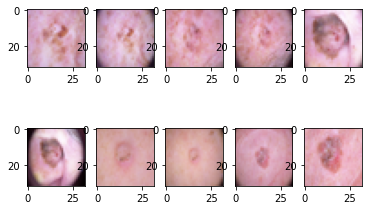

In [41]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [57]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)

In [58]:
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=random.randint(1,99))

In [59]:
# apply oversampling instead of class weight
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(random_state=random.randint(1,99))
train_data = train_data.reshape(8012,image_size*image_size*3)
train_data_oversample, train_label_oversample = smote_sample.fit_resample(train_data, train_label)
train_data_oversample = train_data_oversample.reshape(len(train_data_oversample),image_size,image_size,3)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [60]:
#setup CNN model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#CNN layer 1:
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu',padding='same'))
#try BatchNormalization instead of dropout for over fitting problem
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 2
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 3
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 4
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer
model.add(Flatten())
model.add(Dropout(0.2))

#hidden layer 1
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.2))

#hidden layer 2
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(7,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 64)       

In [61]:
# Train

batch_size = 256
epochs = 20

train_history = model.fit(
    x=train_data_oversample,y=train_label_oversample,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,shuffle=True)

Epoch 1/20
118/118 - 49s - loss: 1.2707 - acc: 0.5436 - val_loss: 6.1813 - val_acc: 0.0000e+00
Epoch 2/20
118/118 - 48s - loss: 0.6372 - acc: 0.7589 - val_loss: 10.8545 - val_acc: 0.0000e+00
Epoch 3/20
118/118 - 48s - loss: 0.5575 - acc: 0.7903 - val_loss: 8.4077 - val_acc: 0.0000e+00
Epoch 4/20
118/118 - 48s - loss: 0.3334 - acc: 0.8721 - val_loss: 7.6327 - val_acc: 0.0128
Epoch 5/20
118/118 - 48s - loss: 0.3106 - acc: 0.8812 - val_loss: 1.7403 - val_acc: 0.5211
Epoch 6/20
118/118 - 48s - loss: 0.3088 - acc: 0.8861 - val_loss: 2.1041 - val_acc: 0.4793
Epoch 7/20
118/118 - 48s - loss: 0.2420 - acc: 0.9087 - val_loss: 0.9039 - val_acc: 0.7751
Epoch 8/20
118/118 - 48s - loss: 0.2528 - acc: 0.9062 - val_loss: 1.9155 - val_acc: 0.5589
Epoch 9/20
118/118 - 48s - loss: 0.1784 - acc: 0.9335 - val_loss: 3.4717 - val_acc: 0.3821
Epoch 10/20
118/118 - 49s - loss: 0.1852 - acc: 0.9330 - val_loss: 1.5806 - val_acc: 0.6901
Epoch 11/20


KeyboardInterrupt: 

In [47]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

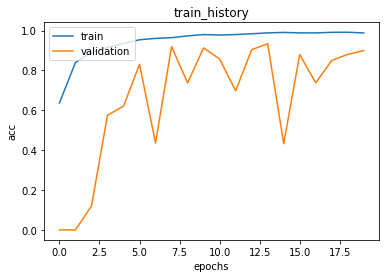

In [48]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

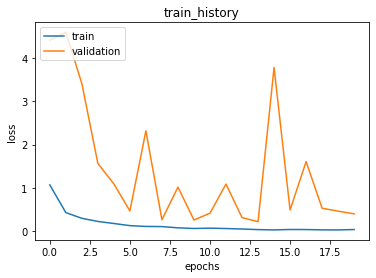

In [49]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [50]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 1s 18ms/step - loss: 1.8959 - acc: 0.6840

In [51]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['label'],colnames=['predict']))


[5 0 5 ... 5 5 4]
predict   0   1   2  3    4     5   6
label                                
0        20   3   4  3   15    20   0
1        13  27   7  4   10    43   8
2         5   2  51  0   80    63   4
3         0   3   3  5    2    14   1
4         5   1  12  1  115    80   4
5         4   4  27  1  171  1130   9
6         0   1   0  0    2     4  22
predict  akiex  bcc  bkl  df  mel    nv  vasc
label                                        
akiex       20    3    4   3   15    20     0
bcc         13   27    7   4   10    43     8
bkl          5    2   51   0   80    63     4
df           0    3    3   5    2    14     1
mel          5    1   12   1  115    80     4
nv           4    4   27   1  171  1130     9
vasc         0    1    0   0    2     4    22
